In [1]:
import warnings

import pandas as pd

for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import hub
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchaudio

from transformers import AutoModelForSequenceClassification, AutoTokenizer

import numpy as np

from sklearn.metrics import f1_score, accuracy_score, classification_report

import scipy

from tqdm import tqdm

from collections import Counter

import matplotlib.pyplot as plt

In [2]:
SEED = 1984

np.random.seed(SEED)
torch.manual_seed(SEED)

gen = torch.Generator()
gen.manual_seed(SEED)

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEQUENCE_LENGTH = 64
MFCC = 128
print(f"It's {DEVICE} time!!!")

It's cuda time!!!


In [4]:
DATA_DIR = os.path.join('..', 'data')

In [5]:
class TextDataset(Dataset):
    
    def __init__(self, data_path):
        self.data = pd.read_csv(data_path)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        return row["acoustic"], row["clean"], row["target"]

In [6]:
train_dataset = TextDataset(os.path.join(DATA_DIR, "train_text_data.csv"))
val_dataset = TextDataset(os.path.join(DATA_DIR, "val_text_data.csv"))
test_dataset = TextDataset(os.path.join(DATA_DIR, "test_text_data.csv"))

# Балансировка классов для train
train_labels = train_dataset.data["target"]
class_counts = Counter(train_labels)
if len(class_counts) < 2:
    raise ValueError("Один из классов отсутствует в тренировочном наборе")

class_weights = {label: 1.0 / count for label, count in class_counts.items()}
weights = [class_weights[label] for label in train_dataset.data["target"]]
train_sampler = WeightedRandomSampler(weights, num_samples=len(train_dataset), replacement=True)


In [7]:
counts = torch.tensor([1 / x[1] for x in sorted(list(class_counts.items()), reverse=False)], dtype=torch.float)
weights = nn.functional.softmax(counts, dim=0)

In [8]:
def collate_fn(batch):
    # print(*batch)
    acoustic, clean, target = zip(*batch)
    pairs = list(zip(acoustic, clean))
    return pairs, torch.tensor(target)

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=4, collate_fn=collate_fn, sampler=train_sampler, drop_last=True, num_workers=6)
# test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=pad_sequence, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, collate_fn=collate_fn, shuffle=False, drop_last=True, num_workers=6)

In [10]:
fgru_hidden_size = 64
tgru_hidden_size = 128

count = 10


def train(model, train_loader, optimizer, criterion, device="cuda", epoch=-1, draw_every=1):
    model.train()
    total_train_loss = 0
    total_train_acc = 0
    total_train_f1 = 0

    for features, target in tqdm(train_loader):
        features, target = features, target.to(device)
        optimizer.zero_grad()
    
        output = model(features)# .logits
        # print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
        preds = torch.argmax(output, dim=-1).cpu().detach().numpy()
        # train_acc.append(accuracy_score(target.cpu().detach().numpy(), preds))
        loss = criterion(output, target)
        # print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
        loss.backward()
        # print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
        optimizer.step()
    
        total_train_loss += loss.detach().item()
        total_train_acc += accuracy_score(target.cpu().detach().numpy(), preds)
        total_train_f1 += f1_score(target.cpu().detach().numpy(), preds, average='macro')
        
    return (model, optimizer, total_train_loss / len(train_loader), 
            total_train_acc / len(train_loader), total_train_f1 / len(train_loader))
            
def evaluate(model, test_loader, criterion, device="cuda", epoch=-1, draw_every=1):
    model.eval()
    total_val_loss = 0
    total_val_acc = 0
    total_val_f1 = 0

    for features, target in tqdm(test_loader):
        features, target = features, target.to(device)
    
        output = model(features)# .logits

        preds = torch.argmax(output, dim=-1).cpu().detach().numpy()
        # train_acc.append(accuracy_score(target.cpu().detach().numpy(), preds))
        loss = criterion(output, target)
        total_val_loss += loss.detach().item()
        total_val_acc += accuracy_score(target.cpu().detach().numpy(), preds)
        total_val_f1 += f1_score(target.cpu().detach().numpy(), preds, average='macro')
        
    return (total_val_loss / len(test_loader), 
            total_val_acc / len(test_loader), total_val_f1 / len(test_loader))

In [11]:
from IPython.display import clear_output

def get_model_name(chkp_folder, model_name=None):
    # Выбираем имя чекпоинта для сохранения
    if model_name is None:
        if os.path.exists(chkp_folder):
            num_starts = len(os.listdir(chkp_folder)) + 1
        else:
            num_starts = 1
        model_name = f'model#{num_starts}'
    else:
        if "#" not in model_name:
            model_name += "#0"
    changed = False
    while os.path.exists(os.path.join(chkp_folder, model_name + '.pt')):
        model_name, ind = model_name.split("#")
        model_name += f"#{int(ind) + 1}"
        changed=True
    if changed:
        warnings.warn(f"Selected model_name was used already! To avoid possible overwrite - model_name changed to {model_name}")
    return model_name

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def learning_loop(
    model,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    scheduler=None,
    min_lr=None,
    epochs=10,
    val_every=1,
    draw_every=1,
    with_noise=True,
    with_rir=True,
    model_name=None,
    chkp_folder="../checkpoints/hubert_chkp",
    plots=None,
    starting_epoch=0,
    device="cuda",
):
    model_name = get_model_name(chkp_folder, model_name)
    
    if plots is None:
        plots = {
            'train loss': [],
            'train acc': [],
            'train f1': [],
            'val loss': [],
            'val acc': [],
            'val f1': [],
            "learning rate": [],
        }
        
    max_f1 = 0

    for epoch in np.arange(1, epochs+1) + starting_epoch:
        print(f'#{epoch}/{epochs}:')

        plots['learning rate'].append(get_lr(optimizer))
        
        model, optimizer, train_loss, train_acc, train_f1 = train(model, train_loader, optimizer,
            criterion, device=device, epoch=epoch, draw_every=draw_every)
        # print(train_nisqa)
        plots['train loss'].append(train_loss)
        plots['train acc'].append(train_acc)
        plots['train f1'].append(train_f1)
        

        if not (epoch % val_every):
            # print("validate")
            val_loss, val_acc, val_f1 = evaluate(model, val_loader, criterion, device=device)
            plots['val loss'].append(val_loss)
            plots['val acc'].append(val_acc)
            plots['val f1'].append(val_f1)
            
            # Сохраняем модель
            if not os.path.exists(chkp_folder):
                os.makedirs(chkp_folder)
            

            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict() if scheduler is not None else None,
                    'plots': plots,
                },
                os.path.join(chkp_folder, model_name + '.pt'),
            )

            
            # Шедулинг
            if scheduler:
                try:
                    scheduler.step()
                except:
                    scheduler.step(metrics=val_loss)

        if not (epoch % draw_every):
            clear_output(True)

            hh = 2
            ww = 2
            plt_ind = 1
            fig, ax = plt.subplots(hh, ww, figsize=(25, 12))
            fig.suptitle(f'#{epoch}/{epochs}:')


            plt.subplot(hh, ww, plt_ind)
            plt.title('Learning rate')
            plt.plot(plots["learning rate"], 'b.-', label='lr', alpha=0.7)
            plt.legend()
            plt_ind += 1

            plt.subplot(hh, ww, plt_ind)
            plt.title('Loss')
            plt.plot(np.arange(1, epoch + 1), plots['train loss'], 'r.-', label='train', alpha=0.7)
            plt.plot(np.arange(1, epoch + 1), plots['val loss'], 'g.-', label='val', alpha=0.7)
            plt.grid()
            plt.legend()
            plt_ind += 1
            
            plt.subplot(hh, ww, plt_ind)
            plt.title('Accuracy')
            plt.plot(np.arange(1, epoch + 1), plots['train acc'], 'r.-', label='train', alpha=0.7)
            plt.plot(np.arange(1, epoch + 1), plots['val acc'], 'g.-', label='val', alpha=0.7)
            plt.grid()
            plt.legend()
            plt_ind += 1
            
            plt.subplot(hh, ww, plt_ind)
            plt.title('F1-score')
            plt.plot(np.arange(1, epoch + 1), plots['train f1'], 'r.-', label='train', alpha=0.7)
            plt.plot(np.arange(1, epoch + 1), plots['val f1'], 'g.-', label='val', alpha=0.7)
            plt.grid()
            plt.legend()
            plt_ind += 1

            plt.show()
            display(fig)
                        
        if min_lr and get_lr(optimizer) <= min_lr:
            print(f'Learning process ended with early stop after epoch {epoch}')
            break

    
    return model, optimizer, plots

In [12]:
class Reranker(nn.Module):
    
    def __init__(self, device="cpu"):
        super(Reranker, self).__init__()
        
        self.tokenizer = AutoTokenizer.from_pretrained('BAAI/bge-reranker-v2-m3')
        self.model = AutoModelForSequenceClassification.from_pretrained('BAAI/bge-reranker-v2-m3')
        self.model.classifier.out_proj = nn.Linear(in_features=1024, out_features=2, bias=True)
        self.model = self.model.to(device)
        # for param in self.tokenizer.parameters():
        #     if not param.requires_grad:
        #         print("something went wrong")
        # print(self.tokenizer.requires_grad, self.model.requires_grad)
        self.sigmoid = nn.Sigmoid()
        self.device = device
        
    def forward(self, text_pairs):
        inputs = self.tokenizer(text_pairs, padding=True, truncation=True, return_tensors='pt', max_length=512)
        # print(inputs["input_ids"].shape, inputs["attention_mask"].shape)
        inputs = inputs.to(self.device)
        outputs = self.model(**inputs).logits.float()
        # print(outputs.shape)
        # outputs = outputs.view(-1,).float()
        # print("success")
        # print(outputs.shape)
        # print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
        return outputs

In [13]:
from torch.optim import Adam, SGD

reranker = Reranker(DEVICE)

optimizer = SGD(reranker.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss().to(DEVICE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, threshold=0.1, mode="min", threshold_mode="abs")

2025-09-03 00:19:27.694162: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-03 00:19:27.704464: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756847967.715643  484325 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756847967.718993  484325 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1756847967.728142  484325 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [14]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

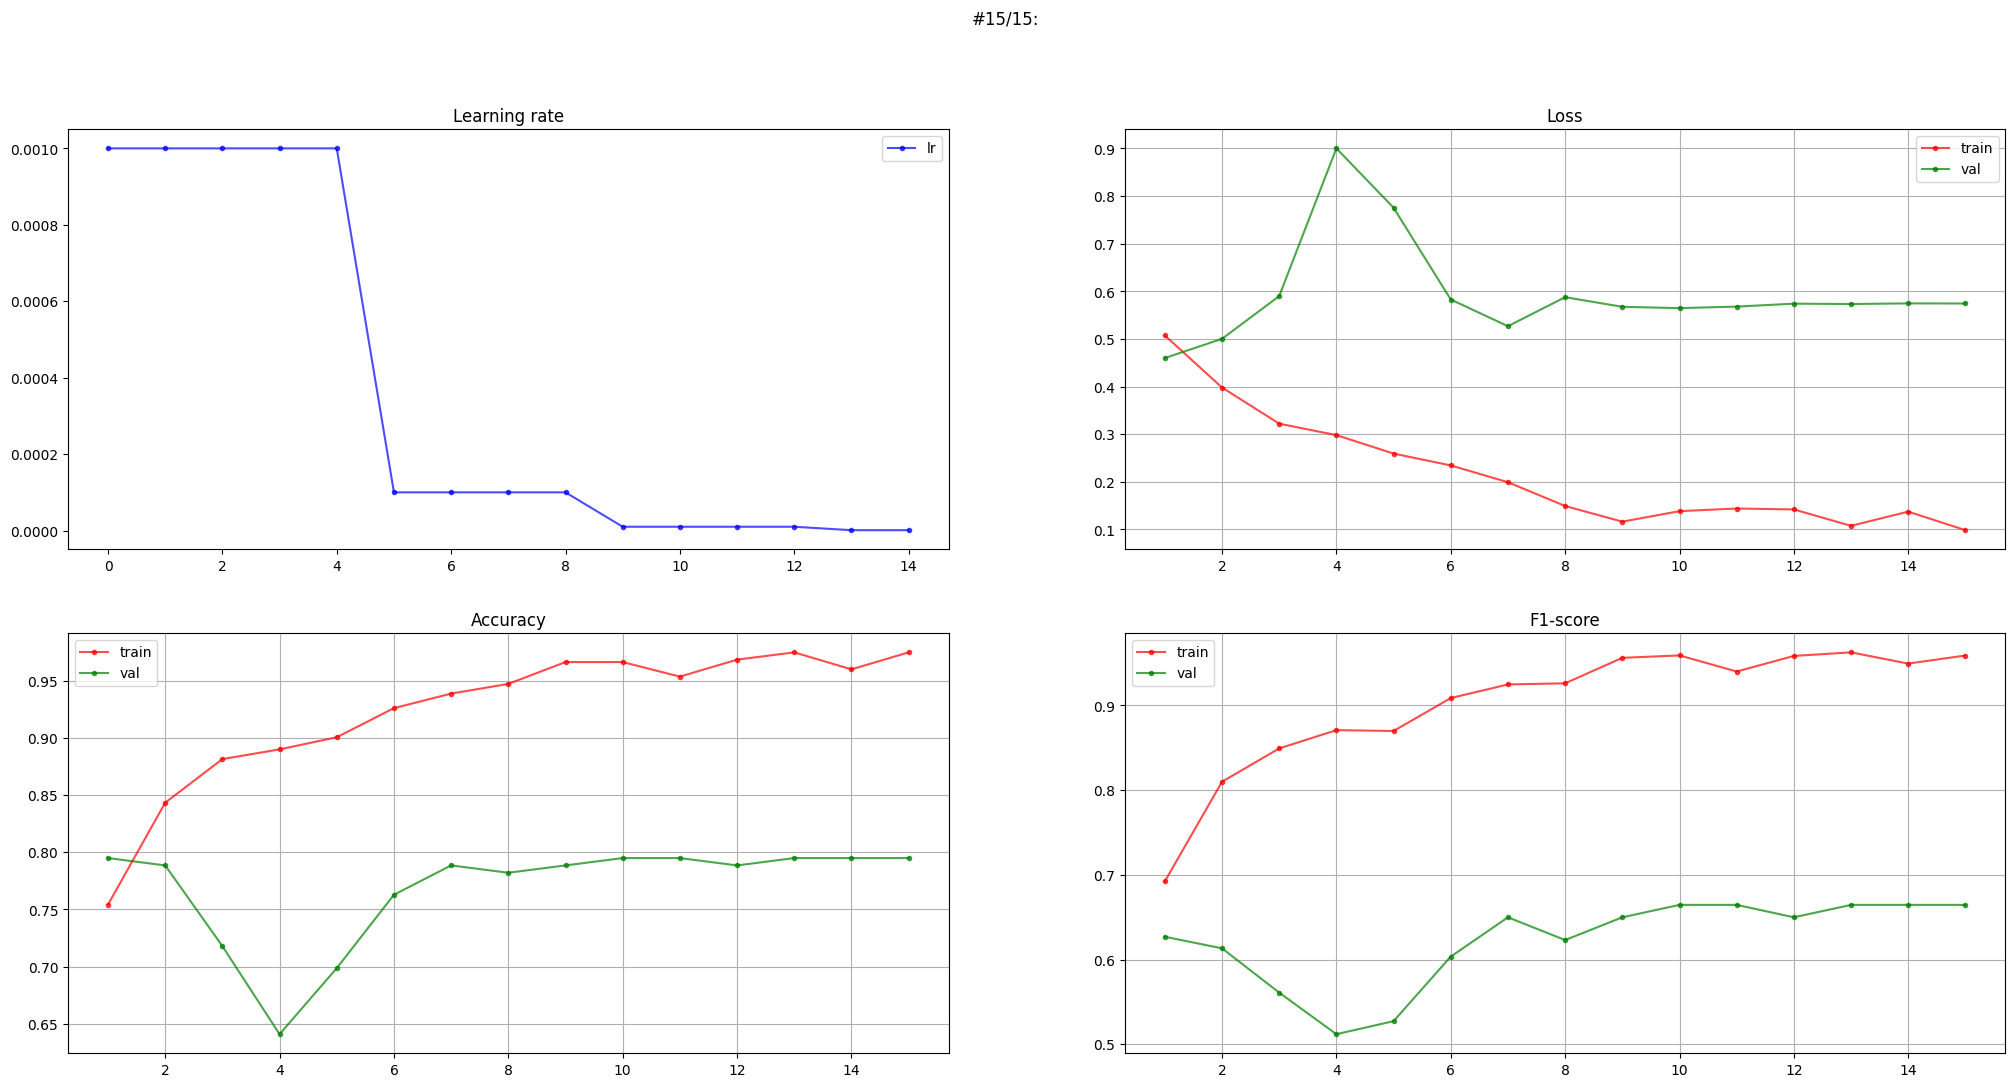

In [15]:
hubert, optimizer, plots = learning_loop(reranker, optimizer, criterion, train_dataloader, val_dataloader, scheduler, draw_every=1, epochs=15, min_lr=1e-7, with_noise=False, with_rir=False, model_name="reranker", chkp_folder="../checkpoints/reranker_ckp",)

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, r2_score

plt.style.use('dark_background')

def test_model(model, test_data):
    model = model.to(DEVICE)

    model.eval()
    scores = []
    targets = []
    with torch.no_grad():
        for acoustic, clean, target in tqdm(test_data):
            output = model([(acoustic, clean)]).to("cpu").detach().numpy().squeeze()
            scores.append(output.argmax(axis=-1))
            targets.append(target)

    scores = np.array(scores)
    targets = np.array(targets)
    # print("RMSE: ", mean_squared_error(targets, scores))
    # print("R^2: ", r2_score(targets, scores))
    # print(targets)
    # preds = np.where(scores > 0.5, 1, 0)
    # print(targets, scores, preds)
    print(classification_report(targets, scores))    
    return scores

In [17]:
test_model(reranker, test_dataset)

100%|██████████| 172/172 [00:01<00:00, 86.46it/s] 

              precision    recall  f1-score   support

           0       0.59      0.71      0.65        42
           1       0.90      0.84      0.87       130

    accuracy                           0.81       172
   macro avg       0.74      0.78      0.76       172
weighted avg       0.82      0.81      0.81       172



array([1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1])